## Анализ и предобработка метаданных товаров Amazon (категория Grocery)

Этот ноутбук посвящён первичной обработке и обогащению товарного каталога из Amazon (категория "Grocery and Gourmet Food").  
Задачи:

- загрузка и очистка данных;
- генерация числовых и категориальных признаков;
- анализ распределений;
- подготовка эмбеддингов CLIP;
- визуализация структуры товаров в пространстве признаков.


In [1]:
# Импорт необходимых библиотек
import gzip
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from PIL import Image
from io import BytesIO
import os
from tqdm import tqdm
import sys


disable_tqdm = os.getenv("TQDM_DISABLE", "0") == "1"

In [2]:
# Загружает Amazon meta-датасет из .json.gz файла
# Если указан limit — ограничивает количество загруженных строк
def load_amazon_meta(path, limit=None):
    data = []
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
            if limit and i + 1 >= limit:
                break
    return pd.DataFrame(data)

In [3]:
# Загружаем полный датасет метаинформации по категории Grocery & Gourmet Food
meta_path = "data/meta_Grocery_and_Gourmet_Food.json.gz"
df_meta = load_amazon_meta(meta_path)

# Описание ключевых колонок датасета
Небольшая справка по структуре загруженного JSON: перечислены основные поля, включая идентификаторы, описание, изображения, категории и цену.
---
`asin` — уникальный идентификатор товара (Amazon Standard Identification Number);  
`title` — название товара;  
`description` — описание товара, часто как список или текст;  
`brand` — бренд или производитель;  
`category` — список категорий (иерархическая структура, как правило от верхнего к нижнему уровня);  
`imageURL` — список URL-адресов картинок низкого разрешения;  
`imageURLHighRes` — список URL-адресов картинок высокого разрешения;  
`also_buy` — список `asin`-ов, которые часто покупают вместе с этим товаром;  
`also_view` — список `asin`-ов, которые часто просматривают вместе с этим товаром;  
`similar_item` — список похожих товаров (может быть пустым);  
`rank` — строка с рангом в категории (например, “#165 in Grocery & Gourmet Food”);  
`main_cat` — основная категория товара;  
`price` — цена товара в строковом формате, например “$19.99”;  
`date` — возможная дата публикации (редко присутствует);  
`tech1`, `tech2`, `feature`, `details` — списки дополнительных характеристик товара (не всегда заполнены);  
`fit` — (в других категориях, например, одежда) — применимость к размеру (в Grocery не используется).


In [4]:
# Быстрый просмотр структуры датафрейма
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287051 entries, 0 to 287050
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         287051 non-null  object
 1   tech1            287051 non-null  object
 2   description      287051 non-null  object
 3   fit              287051 non-null  object
 4   title            287051 non-null  object
 5   also_buy         287051 non-null  object
 6   tech2            287051 non-null  object
 7   brand            287051 non-null  object
 8   feature          287051 non-null  object
 9   rank             287051 non-null  object
 10  also_view        287051 non-null  object
 11  main_cat         287051 non-null  object
 12  similar_item     287051 non-null  object
 13  date             287051 non-null  object
 14  price            287051 non-null  object
 15  asin             287051 non-null  object
 16  imageURL         287051 non-null  object
 17  imageURLHi

In [5]:
df_meta.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",,"[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],,Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,,,$41.91,0681727810,[],[],NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",,"[Shipped from UK, please allow 10 to 21 busine...",,Trim Healthy Mama Xylitol,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",,,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,,,,0853347867,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,[Jazz up your cakes with a sparkling monogram ...,,Letter C - Swarovski Crystal Monogram Wedding ...,[],,Unik Occasions,[],"[>#669,941 in Kitchen & Dining (See Top 100 in...",[B07DXN65TF],Amazon Home,,"September 21, 2010",$29.95,1888861118,[],[],NaN


In [6]:
# Отфильтруем только нужные колонки
# идентификаторы, название, описание, бренд, категории, изображения и цену
keep_columns = [
    "asin", 
    "title", 
    "description", 
    "brand", 
    "category", 
    "imageURL", 
    "imageURLHighRes", 
    "price"
]
df = df_meta[keep_columns].copy()

In [7]:
# Удаляем строки, где отсутствуют ключевые поля: asin или title
# Такие записи не подходят для рекомендаций
df.dropna(subset=["asin", "title"], inplace=True)

In [8]:
# Оставляем только товары с хотя бы одной картинкой (imageURL или imageURLHighRes)
# Остальные отфильтровываются
def has_image(row):
    return bool(row["imageURL"]) or bool(row["imageURLHighRes"])

In [9]:
df = df[df.apply(has_image, axis=1)]

In [10]:
# Универсальная функция для определения "пустых" значений:
# работает для списков, строк и NaN
def is_empty(val):
    if isinstance(val, list):
        return len(val) == 0
    if isinstance(val, str):
        return val.strip() == ""
    if pd.isna(val):
        return True
    return False

In [11]:
# Выводим количество и долю пустых значений по основным колонкам
fields_to_check = ["asin", "title", "description", "brand", "category"]

for col in fields_to_check:
    empty_count = df[col].apply(is_empty).sum()
    print(f"{col}: {empty_count} пустых значений ({round(empty_count / len(df) * 100, 2)}%)")

asin: 0 пустых значений (0.0%)
title: 1 пустых значений (0.0%)
description: 14329 пустых значений (9.54%)
brand: 3704 пустых значений (2.47%)
category: 0 пустых значений (0.0%)


In [12]:
# Дополнительно удаляем записи с пустыми (или пробельными) названиями товаров
df = df[df['title'].str.strip() != '']

In [13]:
# Подставляем "No description." для товаров без описания
df["description"] = df["description"].apply(
    lambda x: x if len(x) > 0 else ["No description."]
)

In [14]:
# Удаляем пробелы и заменяем пустые строки в brand на "unknown"
df["brand"] = df["brand"].str.strip().replace("", "unknown")

In [15]:
# Снова проверяем, остались ли пустые значения после очистки
for col in fields_to_check:
    empty_count = df[col].apply(is_empty).sum()
    print(f"{col}: {empty_count} пустых значений ({round(empty_count / len(df) * 100, 2)}%)")

asin: 0 пустых значений (0.0%)
title: 0 пустых значений (0.0%)
description: 0 пустых значений (0.0%)
brand: 0 пустых значений (0.0%)
category: 0 пустых значений (0.0%)


In [16]:
# Вычисляем длину названия и бинарный признак наличия цифр в нём
df["title_len"] = df["title"].str.len()
df["title_has_digit"] = df["title"].str.contains(r"\d").astype(int)

In [17]:
# Преобразуем строковое значение цены к float:
# Удаляем символ $ и пробелы
# Если указаны два значения через тире (например, "3–5"), берём среднее
# Если парсинг невозможен — возвращаем None
def clean_price(p):
    if isinstance(p, str):
        p = p.replace("$", "").strip()
        if "–" in p or "-" in p:
            parts = re.split(r"[–-]", p)
            try:
                nums = [float(x.strip()) for x in parts if x.strip()]
                if len(nums) == 2:
                    return round(sum(nums) / 2, 2)
            except:
                return None
        try:
            return float(p)
        except:
            return None
    return None

In [18]:
# Применяем функцию очистки к столбцу price и сохраняем в новый столбец price_clean
# Удаляем старый столбец price
df["price_clean"] = df["price"].apply(clean_price)
df.drop("price", axis=1, inplace=True)

In [19]:
print("Доля пустых значений в price_clean:", round(df['price_clean'].isna().mean(), 2))

Доля пустых значений в price_clean: 0.52


In [20]:
# Сводная статистика по числовым признакам датафрейма
df.describe()

,title_len,title_has_digit,price_clean
count,150149.000000,150149.000000,72318.000000
mean,66.077570,0.898847,23.959201
std,32.901391,0.301532,28.145992
min,4.000000,0.000000,0.010000
25%,46.000000,1.000000,10.950000
50%,59.000000,1.000000,17.750000
75%,76.000000,1.000000,28.990000
max,732.000000,1.000000,999.990000


In [21]:
# Сводная статистика по основным категориальным полям
df[["asin", "title", "brand", "category"]].describe()

,asin,title,brand,category
count,150149,150149,150149,150149
unique,148962,147758,24652,1275
top,B0005XMADC,"Grocery &amp; Gourmet Food"" />",unknown,"[Grocery & Gourmet Food, Beverages, Coffee, Te..."
freq,2,278,3704,3857


In [22]:
# Считаем, сколько товаров имеют ровно два вхождения в датафрейме (возможные дубликаты)
(df["asin"].value_counts() == 2).sum()

np.int64(1187)

In [23]:
# Оставляем только последнее вхождение каждого уникального asin
df = df.drop_duplicates(subset="asin", keep="last")
df[["asin", "title", "brand", "category"]].describe()

,asin,title,brand,category
count,148962,148962,148962,148962
unique,148962,147758,24652,1275
top,B01HJFRDDA,"Grocery &amp; Gourmet Food"" />",unknown,"[Grocery & Gourmet Food, Beverages, Coffee, Te..."
freq,1,278,3687,3799


In [24]:
# Извлекаем основную картинку: предпочитаем imageURLHighRes, если доступно
def extract_main_image(row):
    if row["imageURLHighRes"]:
        return row["imageURLHighRes"][0], "high"
    return row["imageURL"][0], "low"

In [25]:
df[['image_main', 'image_source']] = df.apply(extract_main_image, axis=1, result_type="expand")
df.drop(["imageURL", "imageURLHighRes"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
df["image_source"].value_counts()

image_source
high    148962
Name: count, dtype: int64

In [27]:
# Удаление временного признака source качества изображения
df.drop("image_source", axis=1, inplace=True)

In [28]:
# Проверяем финальную структуру после извлечения изображений
df.head(2)

,asin,title,description,brand,category,title_len,title_has_digit,price_clean,image_main
0,0853347867,Trim Healthy Mama Xylitol,"[Shipped from UK, please allow 10 to 21 busine...",unknown,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",25,0,NaN,https://images-na.ssl-images-amazon.com/images...
1,4639725043,Lipton Yellow Label Tea (loose tea) - 450g,[Lipton Yellow Label Tea use only the finest t...,Lipton,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",42,1,12.46,https://images-na.ssl-images-amazon.com/images...


In [29]:
df.shape

(148962, 9)

# EDA

## Проверка качества изображений (image_main)

### 1. Доля битых ссылок

In [30]:
import requests

In [31]:
# Проверка 100 случайных изображений на доступность (валидность ссылки)
def is_image_url_valid(url):
    try:
        response = requests.head(url, timeout=3)
        return response.status_code == 200
    except:
        return False

In [32]:
sample_df = df.sample(n=100, random_state=42).copy()

In [33]:
sample_df["image_main_valid"] = sample_df["image_main"].apply(is_image_url_valid)

# Подсчёт процента и количества битых ссылок среди проверенных
valid_ratio = sample_df['image_main_valid'].mean()
print(f"Доля валидных ссылок: {round(valid_ratio * 100, 2)}%")

Доля валидных ссылок: 99.0%


In [34]:
print(f"Количество битых ссылок в сэмпле: {(~sample_df['image_main_valid']).sum()}")

Количество битых ссылок в сэмпле: 1


### 2. Общая статистика по image_main

In [35]:
print(f"Общее число товаров: {len(df)}")
print(f"Уникальных ссылок image_main: {df['image_main'].nunique()}")

Общее число товаров: 148962
Уникальных ссылок image_main: 139798


По разнице между количеством товаров и уникальных `image_main` видно, что **примерно 9 000 товаров используют одни и те же изображения**. Это может указывать на:
- дубликаты товаров в разных фасовках;
- товары от одного производителя с одним визуальным представлением;
- ошибки или шаблонные страницы.

На данном этапе это **не критично**, но может повлиять на:
- восприятие разнообразия в рекомендациях;
- эмбеддинги при CLIP-инференсе (в будущем можно использовать post-filter).


### 3. Примеры случайных изображений (10–20)

In [36]:
# Функция отрисовки сетки изображений по переданным ссылкам
def show_image_grid(image_urls, n_cols=5, image_size=(3,3)):
    n_rows = (len(image_urls) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(image_size[0]*n_cols, image_size[1]*n_rows)
    )

    for i, url in enumerate(image_urls):
        try:
            img = Image.open(BytesIO(requests.get(url, timeout=3).content))
            axes[i//n_cols, i%n_cols].imshow(img)
            axes[i//n_cols, i%n_cols].axis("off")
        except:
            axes[i//n_cols, i%n_cols].set_title("Error")
            axes[i//n_cols, i%n_cols].axis("off")
    
    for ax in axes.flat[len(image_urls):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

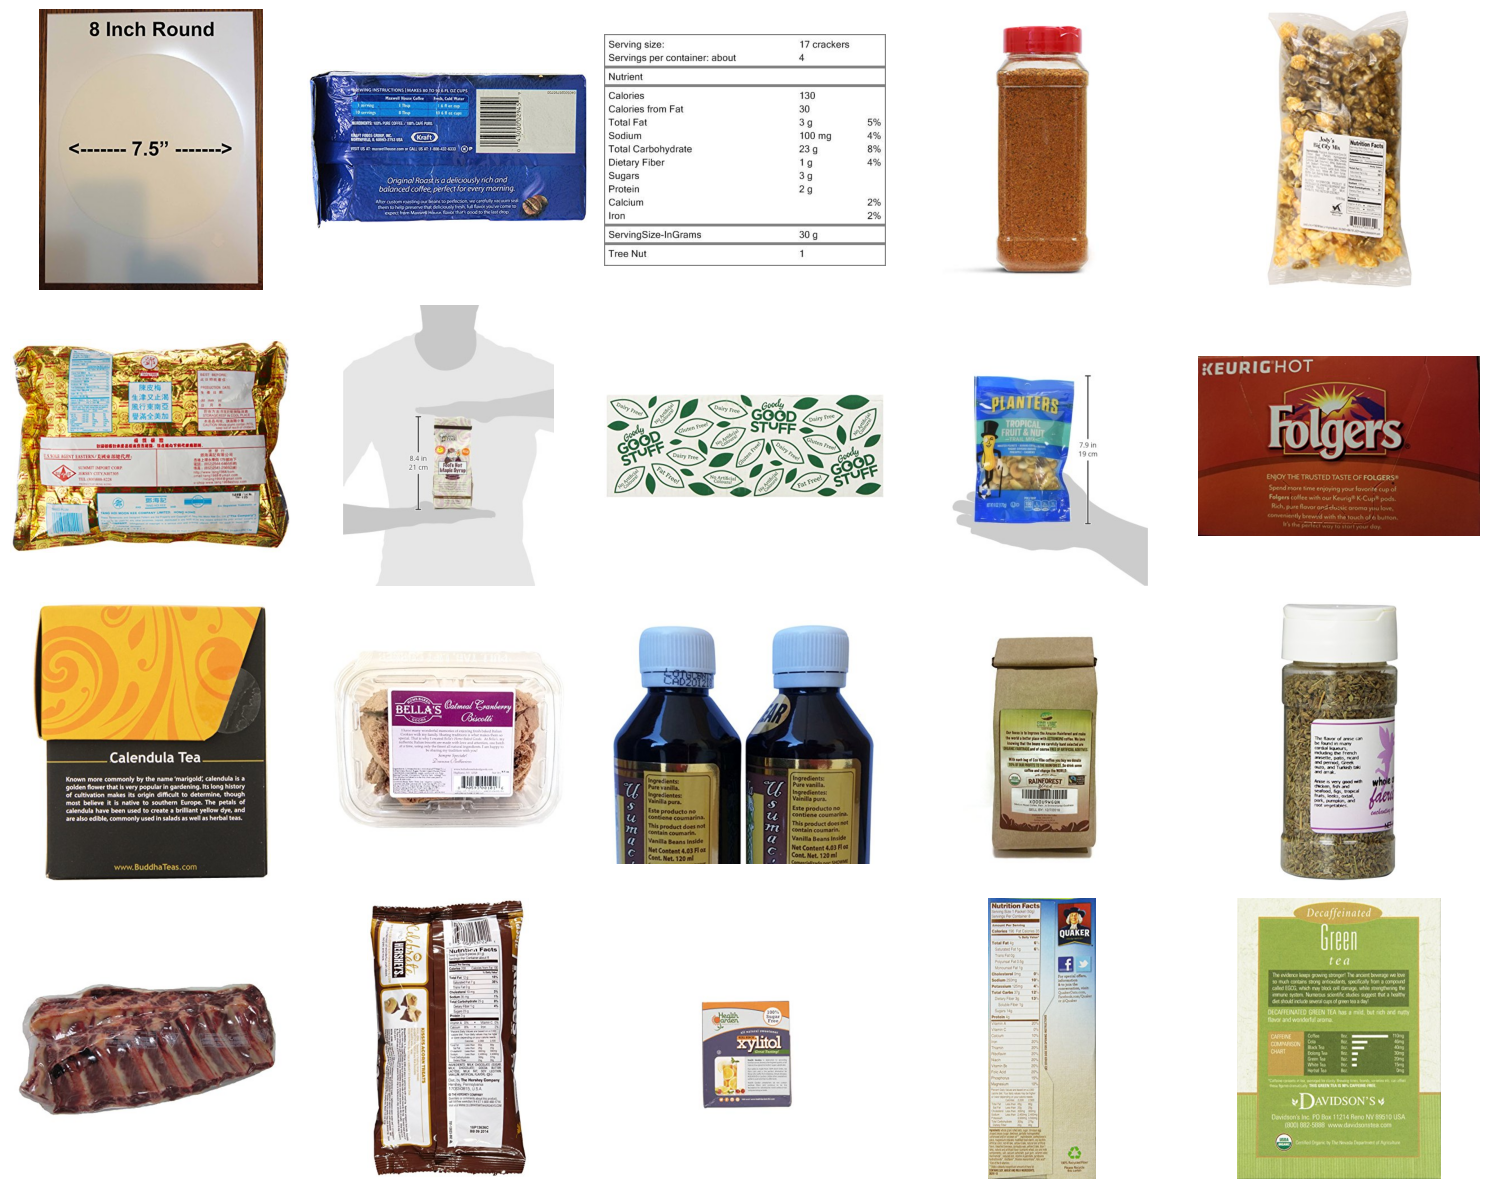

In [37]:
# Показываем 20 случайных картинок
sample_urls = df["image_main"].sample(20, random_state=42).tolist()
show_image_grid(sample_urls)

### 4. Проверка на дубликаты картинок

In [38]:
# Подсчёт числа изображений, которые встречаются более одного раза
duplicate_image_links = df["image_main"].value_counts()
num_duplicates = (duplicate_image_links > 1).sum()
print(f"Количество дублирующихся картинок: {num_duplicates}")

Количество дублирующихся картинок: 4452


Из 148 962 товаров, 139 798 имеют уникальные изображения.
Это означает, что **примерно 9 000** товаров делят одни и те же картинки.
Всего **4 452 дубликатных ссылок** встречаются более одного раза.

## Анализ текстовых и числовых признаков

### 1. title_len: длина заголовка

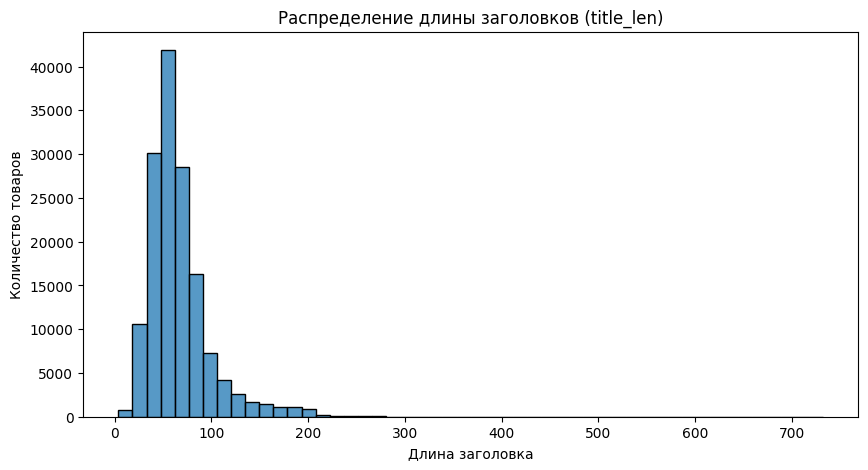

In [39]:
# Строим гистограмму длины заголовков товаров
plt.figure(figsize=(10, 5))
sns.histplot(df["title_len"], bins=50)
plt.title("Распределение длины заголовков (title_len)")
plt.xlabel("Длина заголовка")
plt.ylabel("Количество товаров")
plt.show()

**Выводы по признаку `title_len`**

- Признак `title_len` отражает длину заголовка товара в символах
- Распределение асимметричное вправо, большинство товаров имеют длину названия в диапазоне 50–100 символов, но встречаются значения до 700+
- Значение признака может быть полезным для модели: слишком короткие или длинные названия могут влиять на поведение пользователей и качество рекомендаций

Принятые меры:

- Признак сохранён в исходном виде (`title_len`)
- Нормализация не проводилась, так как модель CatBoost корректно обрабатывает числовые признаки без масштабирования
- При переходе к другим моделям (например, нейросетям) нормализация может быть добавлена позже


### 2. title_has_digit: наличие цифр в заголовке

In [40]:
# Анализ распределения наличия цифр в заголовках (True/False)
df['title_has_digit'].value_counts(normalize=True)

title_has_digit
1    0.899337
0    0.100663
Name: proportion, dtype: float64

**Вывод по признаку `title_has_digit`**

- Бинарный признак, отражающий наличие цифр в названии товара
- Дисбаланс: **~90%** товаров содержат цифры, **~10%** — нет
- Несмотря на смещение, признак оставлен — возможен слабый, но полезный сигнал (например, на фасовку, количество и т.п.)


### 3. price_clean: распределение цен

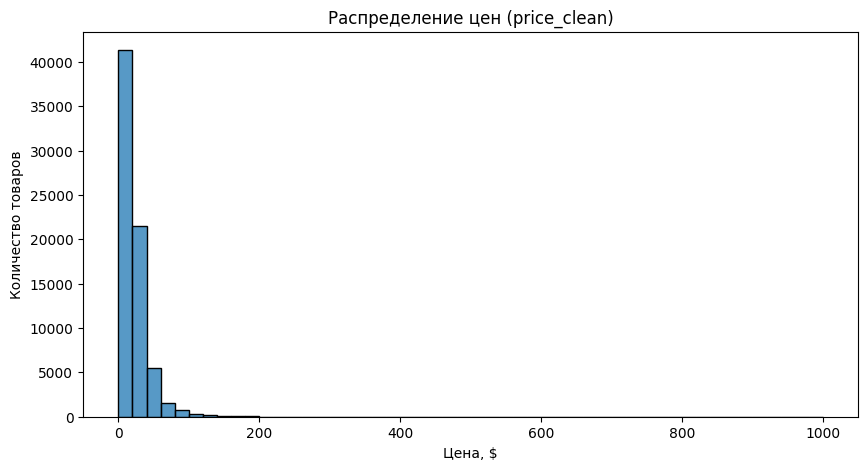

In [41]:
# Строим гистограмму распределения очищенных цен
plt.figure(figsize=(10, 5))
sns.histplot(df["price_clean"].dropna(), bins=50)
plt.title("Распределение цен (price_clean)")
plt.xlabel("Цена, $")
plt.ylabel("Количество товаров")
plt.show()

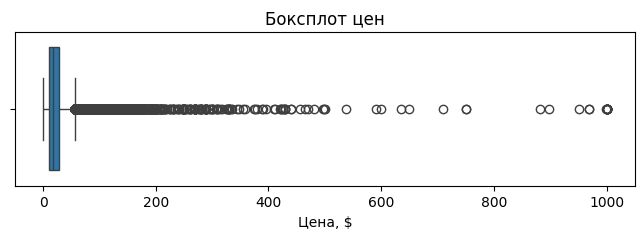

In [42]:
# Строим боксплот для выявления выбросов в ценах
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['price_clean'].dropna())
plt.title("Боксплот цен")
plt.xlabel("Цена, $")
plt.show()

**Обоснование добавления признака `has_price`**

Поле `price_clean` содержит числовые значения цен товаров, очищенные и приведённые к единому формату. Однако более 50% строк в этом поле имеют пропуски (`NaN`), что отражает отсутствие цен в исходных данных.

Для того чтобы модель могла учитывать **сам факт наличия или отсутствия цены** как потенциально важный сигнал (например, отсутствие цены может быть характерно для редких или нестандартных товаров), мы добавим бинарный признак:

- `has_price = 1`, если `price_clean` присутствует;
- `has_price = 0`, если цена отсутствует (`NaN`).

Этот признак поможет модели дифференцировать товары, у которых указана цена, от тех, у которых она скрыта, отсутствует или варьируется.


In [43]:
# Бинарный признак: есть ли указание цены
df["has_price"] = df["price_clean"].notna().astype(int)

### 4. brand: выделим топ-20

Посмотрим, какое у нас количество уникальных брендов.

In [44]:
# Считаем количество уникальных значений брендов
df["brand"].nunique()

24652

In [45]:
# Смотрим частотное распределение 20 самых популярных брендов
df["brand"].value_counts()[:20]

brand
unknown                    3687
Black Tie Mercantile       1446
Trader Joe's                772
McCormick                   588
Unknown                     567
Bob's Red Mill              541
Wholespice                  528
Marshall's Creek Spices     509
faerie's finest             451
Jelly Belly                 443
Starbucks                   417
Frontier                    402
Quantumchaos Media          384
HERSHEY'S                   381
Roland                      379
SweetGourmet                377
Special Tea                 372
Quaker                      366
KaBloom                     366
Betty Crocker               366
Name: count, dtype: int64

Проведем частотный анализ топовой 20-ки брендов для того, чтобы понять, стоит ли его использовать как категориальный признак, т.е.  есть ли 5–10 “сильных” брендов или бренд слишком размыт.

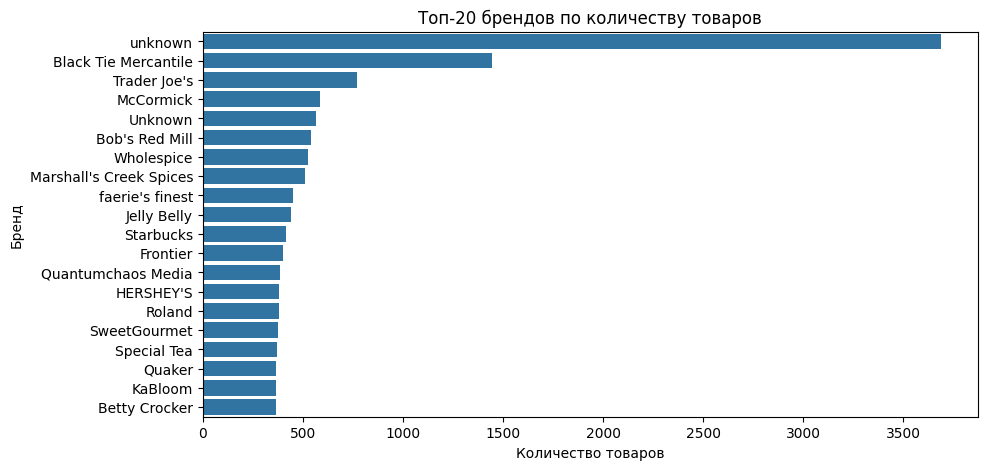

In [46]:
# Строим горизонтальный barplot для 20 самых частых брендов
top_brands = df['brand'].value_counts().head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Топ-20 брендов по количеству товаров")
plt.xlabel("Количество товаров")
plt.ylabel("Бренд")
plt.show()

In [47]:
# Объеденим unknown и Unknown в Unknown
df["brand"] = df["brand"].replace({"unknown": "Unknown"})

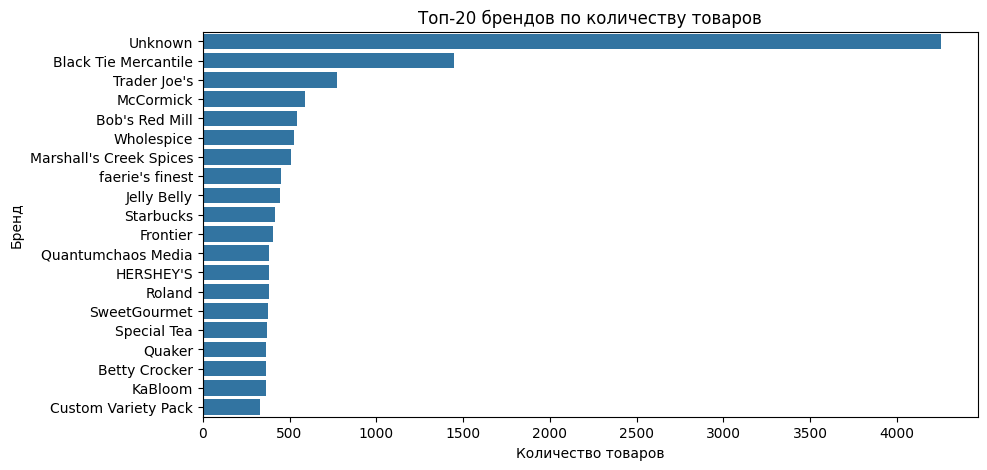

In [48]:
# Обновляем график топ-брендов после объединения значений
top_brands = df['brand'].value_counts().head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Топ-20 брендов по количеству товаров")
plt.xlabel("Количество товаров")
plt.ylabel("Бренд")
plt.show()

In [49]:
# Смотрим обновлённое распределение брендов после унификации
df["brand"].value_counts()[:20]

brand
Unknown                    4254
Black Tie Mercantile       1446
Trader Joe's                772
McCormick                   588
Bob's Red Mill              541
Wholespice                  528
Marshall's Creek Spices     509
faerie's finest             451
Jelly Belly                 443
Starbucks                   417
Frontier                    402
Quantumchaos Media          384
HERSHEY'S                   381
Roland                      379
SweetGourmet                377
Special Tea                 372
Quaker                      366
Betty Crocker               366
KaBloom                     366
Custom Variety Pack         332
Name: count, dtype: int64

**Индикатор топ-брендов**

Бренд может быть важным фактором при выборе товара, однако поле `brand` содержит более **24 000 уникальных значений**, и большинство из них встречаются крайне редко.  

Чтобы помочь модели акцентировать внимание на **наиболее частых брендах**, добавим бинарный признак:

- `is_top20_brand = 1` — если бренд входит в топ-20 по частоте;
- `0` — иначе.

Это позволяет упростить пространство категорий и выделить ключевых игроков рынка без потери признака `brand`, который будет передан в модель как категориальная переменная.


In [50]:
# Добавляем бинарный признак: входит ли бренд в топ-20 по частоте
top_20_brands = df['brand'].value_counts().head(20).index
df['is_top20_brand'] = df['brand'].isin(top_20_brands).astype(int)

**Выводы по признаку `brand`**

- Уникальных брендов: **24 652**
- Отсутствующие значения были объединены и заменены на `'Unknown'`
- `'Unknown'` — самый частый бренд: **4 254 товаров** (~2.9%)
- В топ-20 брендов входят известные производители: Black Tie Mercantile, Trader Joe’s, McCormick, Starbucks, Bob’s Red Mill и др.
- Распределение брендов имеет выраженный **длинный хвост**: большинство брендов встречаются лишь 1–2 раза

Для модели:

- `brand` будет передан в CatBoost как **категориальная переменная**
- Добавлен бинарный признак `is_top20_brand`, принимающий значение:
  - `1` — если бренд входит в топ-20
  - `0` — иначе

Это позволит модели не только учитывать конкретное значение бренда, но и фокусироваться на самых представленных производителях.


### 5. category: топ категории второго уровня

Амазон хранит категории в виде спискапо типу:

```python
['Grocery & Gourmet Food', 'Beverages', 'Coffee']
```

У всех товаров первая категория это `Grocery & Gourmet Food`.
Поэтому возьмем 2-ой уровень категории.

In [51]:
# Извлекаем второй уровень из иерархии категорий и сохраняем в category_main
df["category_main"] = df["category"].apply(
    lambda x: x[1] if isinstance(x, list) and len(x) > 1 else "Unknown"
)
df.drop("category", axis=1, inplace=True)

In [52]:
# Смотрим, сколько уникальных значений имеет новый признак category_main
df["category_main"].nunique()

26

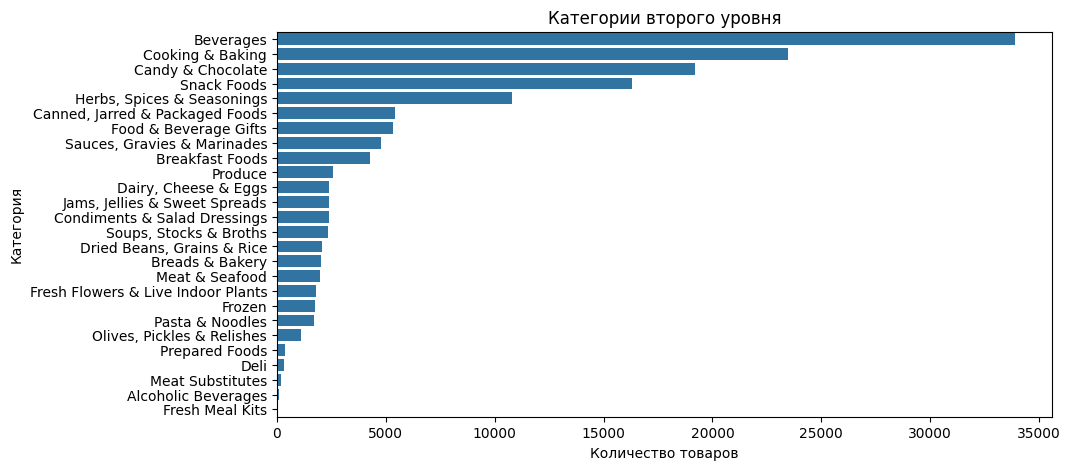

In [53]:
# Визуализируем распределение товаров по category_main (второй уровень)
sorted_categories = df['category_main'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_categories.values, y=sorted_categories.index)
plt.title("Категории второго уровня")
plt.xlabel("Количество товаров")
plt.ylabel("Категория")
plt.show()

In [54]:
# Добавляем бинарный признак: входит ли категория во множество 9 самых частых
top_9_categories  = df["category_main"].value_counts().head(9).index
df["is_top9_category_main"] = df["category_main"].isin(top_9_categories).astype(int)

**Выводы по признаку `category_main`**

- Изначально категория представлялась в виде списка иерархических уровней, например:  
  `['Grocery & Gourmet Food', 'Beverages', 'Coffee']`
- У всех товаров первым элементом была общая категория `'Grocery & Gourmet Food'`, поэтому была извлечена вторая по уровню категория в новое поле `category_main`
- Уникальных значений в `category_main`: **26**
- В топ-9 категорий по количеству товаров входят:
  - Beverages, Cooking & Baking, Candy & Chocolate, Snack Foods,  
    Herbs, Spices & Seasonings, Canned Foods, Gifts, Sauces, Breakfast Foods

Для модели:

- Поле `category_main` будет передано в CatBoost как **категориальная переменная**
- Добавлен бинарный индикатор `is_top9_category_main`, который:
  - принимает `1`, если категория входит в топ-9
  - принимает `0` — во всех остальных случаях

Такой подход позволяет сохранить категориальную информацию и акцентировать внимание модели на наиболее массовых сегментах товаров.


### 6. description: описание продукта

In [55]:
# Оцениваем длину списков описаний и строим их статистику
df['description_len'] = df['description'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['description_len'].describe()

count    148962.000000
mean          2.736087
std           1.838659
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          54.000000
Name: description_len, dtype: float64

Это говорит о том, что:
- В 75% случаев description содержит 1–3 элемента - короткие описания
- Но есть несколько экстремально подробных (до 54 пунктов)
- Это всё ещё удобно склеить в одну строку и использовать как обычный текст

In [56]:
# Показываем список фраз из description для первого товара
for el in df["description"][0]:
    print(el)

Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd
Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.


In [57]:
# Склеиваем список описания в единый текст: 
# очищаем, форматируем и капитализируем
def smart_capitalize(text):
    if not text:
        return text
    return text[0].upper() + text[1:]

def clean_description(desc):
    if not isinstance(desc, list):
        return str(desc).strip()
    
    phrases = []
    for part in desc:
        part = str(part).strip()
        if not part or part.lower() in ["none", "nan"]:
            continue
        
        part = re.sub(r"\s+", ' ', part)

        sentences = re.split(r"(?<=[.!?])\s+", part)
        sentences = [smart_capitalize(s.strip()) for s in sentences if s.strip()]
        part = ". ".join(sentences)
        
        if part.endswith("."):
            part = part[:-1]
        
        phrases.append(part)
    
    result = ". ".join(phrases) + ("." if phrases else "No description.")
    result = re.sub(r'\.{2,}', '.', result)

    return result

In [58]:
df["description_text"] = df["description"].apply(clean_description)

In [59]:
# Показываем итоговое текстовое описание для первого товара
df["description_text"][0]

'Shipped from UK, please allow 10 to 21 business days for arrival. Ex lib pub by Applied Science Publishers ltd. Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'

In [60]:
# Посмотрим длину описаний в символах
df['description_text_len'] = df['description_text'].str.len()
df['description_text_len'].describe()

count    148962.000000
mean        672.896591
std         625.759944
min           1.000000
25%         283.000000
50%         523.000000
75%         885.000000
max       10660.000000
Name: description_text_len, dtype: float64

In [61]:
# Заменяем слишком короткие описания на "No description" и пересчитываем длину
df["description_word_count"] = df["description_text"].apply(lambda x: len(x.split()))
df.loc[df["description_word_count"] < 3, "description_text"] = "No description."
df.drop(columns="description_word_count", inplace=True)
df["description_text_len"] = df["description_text"].str.len()

In [62]:
df['description_text_len'].describe()

count    148962.000000
mean        672.898645
std         625.757754
min          11.000000
25%         283.000000
50%         523.000000
75%         885.000000
max       10660.000000
Name: description_text_len, dtype: float64

In [63]:
# Выводим примеры случайных описаний для 
# визуального контроля качества обработки
for text in df['description_text'].sample(5, random_state=42).tolist():
    print("-----------------")
    print(text)

-----------------
Edible icing art is a great way to make a cake and cupcakes look fantastic and professional. These are an easy and inexpensive way to make your cake look like a masterpiece. All icing images come with instructions . Simply remove the edible icing art from backing and place on top of freshly iced cake or cupcakes. After 15 to 25 minutes the edible icing art will blend with the frosting to give your cake a professional look. Prints are professionally printed on compressed icing sheets. Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.
-----------------
Maxwell House Coffee Original Roast Ground Medium. One 11.5 brick. 100% Pure Coffee. Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.
-----------------
Blue Diamond Nut Thins Almonds Honey C

In [64]:
# Удаляем необработанное описание и вспомогательный признак, 
# т.к. теперь используется description_text
df.drop(columns=["description", "description_len"], inplace=True)

**Резюме по анализу поля description**

Поле `description` представляло собой список коротких фраз, описывающих товар. Для подготовки к обработке текстовыми моделями была проведена очистка и трансформация:

**Основные шаги:**
- Удалены пустые или мусорные элементы (`['']`, `None`, `'nan'`)
- Список склеен в читаемый текст с помощью `. ` между элементами
- Каждое предложение приведено к нормальной пунктуации: заглавная буква, одна точка в конце
- Короткие или бессмысленные описания (менее 3 слов) заменены на `No description.`

**Оставленные фичи:**
- `description_text` — текстовое описание, готовое для эмбеддинга
- `description_text_len` — длина итогового текста в символах (может использоваться как числовой признак)

**Удалённые фичи:**
- `description` — оригинальный список (устарел)
- `description_len` — количество элементов в списке (избыточно после получения длины текста)

Результат — чистый текст, пригодный для подачи в `CLIP`, `SBERT` или другие текстовые энкодеры, а также числовая оценка его длины.



In [65]:
# Объединяем название и описание в единый текстовый признак 
# для мультимодального анализа
df["text_full"] = df["title"] + ". " + df["description_text"]

**Признак `text_full` (объединение `title` + `description_text`)**

- Для создания мультимодального текстового эмбеддинга (в модели `CLIP` или `SBERT`) мы объединили название товара и его описание в единое текстовое поле `text_full`
- Это позволяет получить более информативное и контекстное представление товара, чем использование `title` или `description_text` по отдельности

Поле `text_full` будет использоваться для генерации текстовых эмбеддингов на этапе обучения улучшенной модели, а поля `title` и `description_text` удалим.


In [66]:
# Выводим список колонок после всех преобразований
df.columns.tolist()

['asin',
 'title',
 'brand',
 'title_len',
 'title_has_digit',
 'price_clean',
 'image_main',
 'has_price',
 'is_top20_brand',
 'category_main',
 'is_top9_category_main',
 'description_text',
 'description_text_len',
 'text_full']

In [67]:
# Определяем финальный порядок колонок в датасете
column_order = [
    "asin",
    "title_len",
    "title_has_digit",
    "description_text_len",
    "text_full",
    "brand",
    "is_top20_brand",
    "price_clean",
    "has_price",
    "category_main",
    "is_top9_category_main",
    "image_main"
]

df = df[column_order]

In [68]:
# Проверяем, как выглядит датафрейм после финальной структуризации
df.head(2)

,asin,title_len,title_has_digit,description_text_len,text_full,brand,is_top20_brand,price_clean,has_price,category_main,is_top9_category_main,image_main
0,0853347867,25,0,278,"Trim Healthy Mama Xylitol. Shipped from UK, pl...",Unknown,1,NaN,0,Cooking & Baking,1,https://images-na.ssl-images-amazon.com/images...
1,4639725043,42,1,406,Lipton Yellow Label Tea (loose tea) - 450g. Li...,Lipton,0,12.46,1,Beverages,1,https://images-na.ssl-images-amazon.com/images...


## Структура итогового датасета `amazon_meta_clean`

После полной предобработки и EDA в финальный датасет вошли только те признаки, которые несут полезную информацию для моделей. Поля структурированы по смысловым группам:

### Основное
- `asin` — уникальный идентификатор товара

### Название товара
- `title_len` — длина заголовка (в символах)
- `title_has_digit` — бинарный признак наличия цифр в заголовке

### Текстовое описание
- `text_full` — объединённое поле: `title + ". " + description_text`
- `description_text_len` — длина итогового текстового описания (в символах)

### Бренд
- `brand` — название бренда
- `is_top20_brand` — бинарный признак: входит ли бренд в топ-20 самых частых

### Цена
- `price_clean` — очищенное числовое значение цены
- `has_price` — бинарный признак: указана ли цена

### Категория
- `category_main` — категория второго уровня (основная товарная категория)
- `is_top9_category_main` — бинарный признак: входит ли категория в топ-9

### Изображение
- `image_main` — ссылка на главное изображение товара

Все текстовые и категориальные признаки готовы к подаче в CatBoost или эмбеддинг-модели (CLIP, SBERT). Датасет сбалансирован по размеру, интерпретируем и пригоден для мультимодального моделирования.


## Качаем изображения

In [69]:
# Создаём папку для изображений и формируем пары (asin, url) для скачивания
os.makedirs("data/images", exist_ok=True)
image_links = list(zip(df["asin"], df["image_main"]))
image_links[:2]

[('0853347867',
  'https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL.jpg'),
 ('4639725043',
  'https://images-na.ssl-images-amazon.com/images/I/31V3NfjNACL.jpg')]

In [70]:
# Устанавливаем заголовок User-Agent для обхода ограничений при скачивании
headers = {
    "User-Agent": "Mozilla/5.0"
}

In [71]:
# Импортируем потоки и инициализируем список для ошибок
from concurrent.futures import ThreadPoolExecutor
from threading import Lock

In [72]:
failed_asin_url = []
lock = Lock()

In [73]:
# Функция скачивает изображение по URL, сохраняет по пути data/images/{asin}.jpg
# Ошибки и неуспешные статусы логируются в список failed_asin_url
def download_image(args):
    asin, url = args
    path = f"data/images/{asin}.jpg"
    if os.path.exists(path):
        return
    try:
        with requests.Session() as session:
            response = session.get(url, headers=headers, timeout=10, stream=True)
            if response.status_code == 200:
                with open(path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            else:
                with lock:
                    failed_asin_url.append((asin, url, response.status_code))
                tqdm.write(f"[ERROR] ASIN {asin}: Status code {response.status_code}")
    except Exception as e:
        with lock:
            failed_asin_url.append((asin, url, str(e)))
        tqdm.write(f"[ERROR] ASIN {asin}: {e}")

In [74]:
# Запускаем первую параллельную загрузку изображений с прогресс-баром
with ThreadPoolExecutor(max_workers=16) as executor:
    list(tqdm(executor.map(download_image, image_links), total=len(image_links), desc="Downloading images", file=sys.stdout, disable=disable_tqdm))

[ERROR] ASIN B000JYJBOI: Status code 404                                   
[ERROR] ASIN B000JYZENK: Status code 404                                  
[ERROR] ASIN B000M6XILU: Status code 404                                  
[ERROR] ASIN B000QNNW88: Status code 404                                  
[ERROR] ASIN B002LM9G3W: HTTPSConnectionPool(host='images-na.ssl-images-amazon.com', port=443): Read timed out. (read timeout=10)
[ERROR] ASIN B003Z9V2PK: Status code 404                                     
[ERROR] ASIN B006SQDGEC: Status code 404                                    
[ERROR] ASIN B0070R045W: Status code 404                                   
[ERROR] ASIN B00BLN7QN4: Status code 404                                   
[ERROR] ASIN B00E0M72TQ: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))
[ERROR] ASIN B00E0M2SCM: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принуд

In [75]:
# Повторная попытка дозагрузить изображения, у которых
# не 404 ошибка
retry_list = []
final_failed = []

In [76]:
for asin, url, err in failed_asin_url:
    if isinstance(err, int) and err == 404:
        final_failed.append((asin, url))
    else:
        retry_list.append((asin, url))

In [77]:

print(f"\nRetrying {len(retry_list)} images with non-404 errors...")


Retrying 6 images with non-404 errors...


In [78]:
def retry_download(args):
    asin, url = args
    path = f"data/images/{asin}.jpg"
    try:
        with requests.Session() as session:
            response = session.get(url, headers=headers, timeout=10, stream=True)
            if response.status_code == 200:
                with open(path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            else:
                final_failed.append((asin, url))
                tqdm.write(f"[RETRY ERROR] ASIN {asin}: Status code {response.status_code}")
    except Exception as e:
        final_failed.append((asin, url))
        tqdm.write(f"[RETRY ERROR] ASIN {asin}: {e}")

In [79]:
with ThreadPoolExecutor(max_workers=16) as executor:
    list(tqdm(executor.map(retry_download, retry_list), total=len(retry_list), desc="Retrying failed", file=sys.stdout, disable=disable_tqdm))

Retrying failed: 100%|██████████| 6/6 [00:00<00:00, 44.73it/s]


In [80]:
# Выводим список товаров, для которых загрузка изображений не удалась
print("Failed ASINs with url:", *final_failed, sep="\n")
print("Len ASINs list:", len(final_failed))

Failed ASINs with url:
('B000JYJBOI', 'https://images-na.ssl-images-amazon.com/images/I/51GTF%2BRCDEL.jpg')
('B000JYZENK', 'https://images-na.ssl-images-amazon.com/images/I/51GTF%2BRCDEL.jpg')
('B000M6XILU', 'https://images-na.ssl-images-amazon.com/images/I/41tNhZerkPL.jpg')
('B000QNNW88', 'https://images-na.ssl-images-amazon.com/images/I/41WHljXWJpL.jpg')
('B003Z9V2PK', 'https://images-na.ssl-images-amazon.com/images/I/51JHonMgY9L.jpg')
('B006SQDGEC', 'https://images-na.ssl-images-amazon.com/images/I/31HRlV8tC-L.jpg')
('B0070R045W', 'https://images-na.ssl-images-amazon.com/images/I/4164Npm-7RL.jpg')
('B00BLN7QN4', 'https://images-na.ssl-images-amazon.com/images/I/41o1kuQe38L.jpg')
('B00GNCKE4Q', 'https://images-na.ssl-images-amazon.com/images/I/512BvqQcFaL.jpg')
('B00I6AN2W4', 'https://images-na.ssl-images-amazon.com/images/I/51J4Ua9rzgL.jpg')
('B00PKLVEQ8', 'https://images-na.ssl-images-amazon.com/images/I/61snxFH6r2L.jpg')
('B00TGBU4BE', 'https://images-na.ssl-images-amazon.com/imag

In [81]:
# Получаем список всех успешно скачанных изображений по их asin
image_dir = "data/images"
existing_images = set(os.listdir(image_dir))
existing_asins = set(f.replace(".jpg", "") for f in existing_images)

In [82]:
# Удаляем из датафрейма товары без скачанных изображений
df = df[df["asin"].isin(existing_asins)].copy()

In [83]:
print(f"После фильтрации по изображениям: {len(df):,} товаров")

После фильтрации по изображениям: 148,948 товаров


# UMAP

In [84]:
# Импортируем библиотеки для обработки изображений и работы с моделью CLIP
import torch
import open_clip
import numpy as np

c:\Users\Администратор\Desktop\START_ML\Проект\MFDP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Извлечение эмбеддингов с помощью CLIP

Используем модель CLIP (ViT-B/32), чтобы получить семантические эмбеддинги:
- из текстового описания (text_full);
- из изображения товара (image_main, при наличии).


In [85]:
# Загружаем предобученную модель CLIP и 
# соответствующие токенизаторы
device = "cuda" if torch.cuda.is_available() else "cpu"

In [86]:
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-32", pretrained="laion2b_s34b_b79k"
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")
model = model.to(device)

In [87]:
# Текстовые эмбеддинги
text_features = []
for text in tqdm(df["text_full"], desc="Text embeddings", file=sys.stdout, disable=disable_tqdm):
    tokenized = tokenizer([text]).to(device)
    with torch.no_grad():
        emb = model.encode_text(tokenized)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    text_features.append(emb.cpu().squeeze().numpy())
text_features = np.stack(text_features)

Text embeddings: 100%|██████████| 148948/148948 [17:37<00:00, 140.83it/s]


In [88]:
# Картиночные эмбеддинги
# при ошибке — заполняем нулями
image_features = []
for asin in tqdm(df["asin"], desc="Image embeddings", file=sys.stdout, disable=disable_tqdm):
    path = f"data/images/{asin}.jpg"
    try:
        image = Image.open(path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(image_tensor)
            emb = emb / emb.norm(dim=-1, keepdim=True)
        image_features.append(emb.cpu().squeeze().numpy())
    except Exception as e:
        tqdm.write(f"[WARN] Failed to process {asin}: {e}")
        image_features.append(np.zeros(512))
image_features = np.stack(image_features)

Image embeddings: 100%|██████████| 148948/148948 [25:35<00:00, 97.02it/s] 


In [89]:
# Снижаем размерность CLIP-эмбеддингов текста и изображений 
# с 512 до 100 с помощью PCA
from sklearn.decomposition import PCA
pca_text = PCA(n_components=100, random_state=42)
pca_img = PCA(n_components=100, random_state=42)

In [90]:
# Преобразуем PCA-признаки в DataFrame и 
# добавляем идентификаторы товаров (asin)
clip_text_pca = pca_text.fit_transform(text_features)
clip_img_pca = pca_img.fit_transform(image_features)

In [91]:
# Преобразуем в DataFrame с ключом asin
df_text = pd.DataFrame(clip_text_pca, columns=[f"clip_text_{i+1}" for i in range(100)])
df_text["asin"] = df["asin"].values

In [92]:
df_img = pd.DataFrame(clip_img_pca, columns=[f"clip_img_{i+1}" for i in range(100)])
df_img["asin"] = df["asin"].values

In [93]:
# Объединяем текстовые и визуальные эмбеддинги с 
# основным датафреймом по asin
df = df.merge(df_text, on="asin", how="left")
df = df.merge(df_img, on="asin", how="left")

In [94]:
# Заполняем пропущенные значения цены и стандартизируем числовые признаки
from sklearn.preprocessing import StandardScaler

In [95]:
df["price_clean"] = df["price_clean"].fillna(-1)
scaler = StandardScaler()
df[["title_len", "description_text_len", "price_clean"]] = scaler.fit_transform(
    df[["title_len", "description_text_len", "price_clean"]]
)

In [96]:
# Проверяем итоговый вид датафрейма и перечень колонок
df.head(1)

,asin,title_len,title_has_digit,description_text_len,text_full,brand,is_top20_brand,price_clean,has_price,category_main,...,clip_img_91,clip_img_92,clip_img_93,clip_img_94,clip_img_95,clip_img_96,clip_img_97,clip_img_98,clip_img_99,clip_img_100
0,0853347867,-1.251232,0,-0.631098,"Trim Healthy Mama Xylitol. Shipped from UK, pl...",Unknown,1,-0.518064,0,Cooking & Baking,...,-0.01848,0.00149,-0.009414,-0.020092,0.017877,-0.013981,-0.019704,0.006714,-0.014309,-0.016338


In [97]:
df.columns.tolist()

['asin',
 'title_len',
 'title_has_digit',
 'description_text_len',
 'text_full',
 'brand',
 'is_top20_brand',
 'price_clean',
 'has_price',
 'category_main',
 'is_top9_category_main',
 'image_main',
 'clip_text_1',
 'clip_text_2',
 'clip_text_3',
 'clip_text_4',
 'clip_text_5',
 'clip_text_6',
 'clip_text_7',
 'clip_text_8',
 'clip_text_9',
 'clip_text_10',
 'clip_text_11',
 'clip_text_12',
 'clip_text_13',
 'clip_text_14',
 'clip_text_15',
 'clip_text_16',
 'clip_text_17',
 'clip_text_18',
 'clip_text_19',
 'clip_text_20',
 'clip_text_21',
 'clip_text_22',
 'clip_text_23',
 'clip_text_24',
 'clip_text_25',
 'clip_text_26',
 'clip_text_27',
 'clip_text_28',
 'clip_text_29',
 'clip_text_30',
 'clip_text_31',
 'clip_text_32',
 'clip_text_33',
 'clip_text_34',
 'clip_text_35',
 'clip_text_36',
 'clip_text_37',
 'clip_text_38',
 'clip_text_39',
 'clip_text_40',
 'clip_text_41',
 'clip_text_42',
 'clip_text_43',
 'clip_text_44',
 'clip_text_45',
 'clip_text_46',
 'clip_text_47',
 'clip_tex

In [98]:
# Импортируем библиотеку для визуализации эмбеддингов (UMAP)
import umap.umap_ as umap

In [99]:
# Собираем CLIP-эмбеддинги и табличные признаки в единый массив для UMAP
clip_text_cols = [col for col in df.columns if col.startswith("clip_text_")]
clip_img_cols = [col for col in df.columns if col.startswith("clip_img_")]
extra_vec_cols = [
    "title_len",
    "description_text_len",
    "is_top20_brand",
    "has_price",
    "is_top9_category_main",
    "price_clean"
]

In [100]:
umap_features = df[clip_text_cols + clip_img_cols + extra_vec_cols].values

In [101]:
# Определяем топ-9 категорий и назначаем им цвета, 
# остальные отмечаем как "Other"
top_categories = df["category_main"].value_counts().nlargest(9).index.tolist()

In [102]:
top9_cats = df["category_main"].apply(lambda x: x if x in top_categories else "Other")

In [103]:
palette = sns.color_palette("tab10", n_colors=len(top_categories))
palette_dict = {cat: color for cat, color in zip(top_categories, palette)}
palette_dict["Other"] = "lightgray"

c:\Users\Администратор\Desktop\START_ML\Проект\MFDP\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Администратор\Desktop\START_ML\Проект\MFDP\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


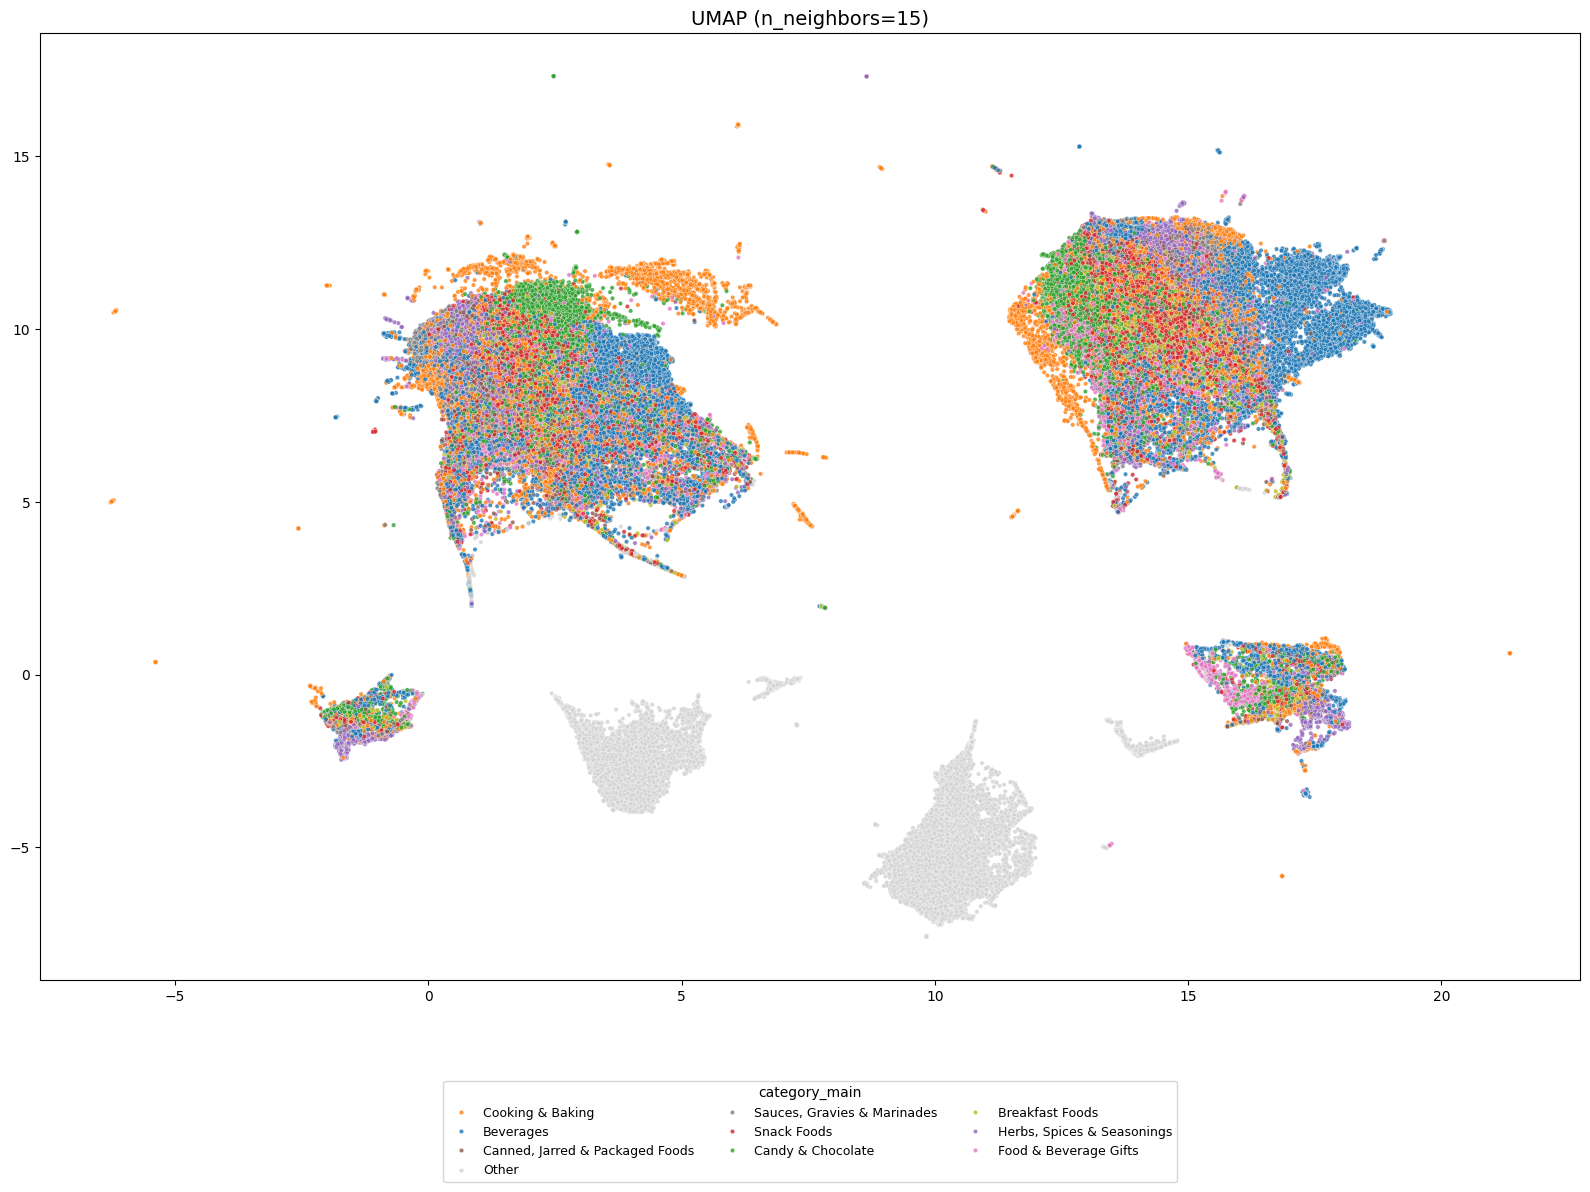

In [104]:
# Визуализируем товары в 2D-пространстве на основе эмбеддингов и признаков
plt.figure(figsize=(16, 12))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
embedding = reducer.fit_transform(umap_features)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=top9_cats,
    palette=palette_dict,
    s=10,
    alpha=0.8,
    legend="full"
)

plt.title(f"UMAP (n_neighbors=15)", fontsize=14)

plt.legend(
    title="category_main",
    bbox_to_anchor=(0.5, -0.1),
    loc="upper center",
    ncol=3,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.show()

### Визуализация эмбеддингов товаров через UMAP

На графике представлено двумерное отображение мультимодальных признаков товаров: **текстовые и визуальные эмбеддинги из CLIP**, дополненные табличными признаками (`title_len`, `description_text_len`, `brand`, `price_clean` и др.). Для снижения размерности используется **UMAP (Uniform Manifold Approximation and Projection)**.

Цветом выделены **топ-9 категорий товаров**, остальные отнесены к классу `"Other"` и показаны серым.

#### Выводы:

* Модель **формирует осмысленные кластеры**: товары схожих категорий (`Beverages`, `Cooking & Baking`, `Snack Foods`) сгруппированы вместе;
* **Компактность и отделённость кластеров** говорит о высоком качестве признаков;
* **Наличие промежуточных областей** между группами отражает близкие по смыслу категории;
* Визуализация подтверждает, что **мультимодальные эмбеддинги успешно захватывают категориальную структуру ассортимента**.

> Такая структура эмбеддингов является хорошим основанием как для рекомендаций, так и для кластеризации или поиска похожих товаров.



In [105]:
# Строим TF-IDF векторы по объединённому полю text_full
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [106]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5)
X_text = vectorizer.fit_transform(df["text_full"])

In [107]:
# Масштабируем TF-IDF признаки и уменьшаем размерность 
# до 100 компонент с помощью PCA
scaler = StandardScaler()
X_text_scaled = scaler.fit_transform(X_text.toarray())

In [108]:
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X_text_scaled)

In [109]:
# Преобразованные признаки PCA добавляем к основному датафрейму по ключу asin
df_tfidf = pd.DataFrame(X_reduced, columns=[f"tfidf_{i+1}" for i in range(X_reduced.shape[1])])
df_tfidf["asin"] = df["asin"].values

In [110]:
# Объединяем с основным df
df = df.merge(df_tfidf, on="asin", how="left")

In [111]:
# Проверяем имена колонок и финальный размер датафрейма
df.columns.tolist(), df.shape

(['asin',
  'title_len',
  'title_has_digit',
  'description_text_len',
  'text_full',
  'brand',
  'is_top20_brand',
  'price_clean',
  'has_price',
  'category_main',
  'is_top9_category_main',
  'image_main',
  'clip_text_1',
  'clip_text_2',
  'clip_text_3',
  'clip_text_4',
  'clip_text_5',
  'clip_text_6',
  'clip_text_7',
  'clip_text_8',
  'clip_text_9',
  'clip_text_10',
  'clip_text_11',
  'clip_text_12',
  'clip_text_13',
  'clip_text_14',
  'clip_text_15',
  'clip_text_16',
  'clip_text_17',
  'clip_text_18',
  'clip_text_19',
  'clip_text_20',
  'clip_text_21',
  'clip_text_22',
  'clip_text_23',
  'clip_text_24',
  'clip_text_25',
  'clip_text_26',
  'clip_text_27',
  'clip_text_28',
  'clip_text_29',
  'clip_text_30',
  'clip_text_31',
  'clip_text_32',
  'clip_text_33',
  'clip_text_34',
  'clip_text_35',
  'clip_text_36',
  'clip_text_37',
  'clip_text_38',
  'clip_text_39',
  'clip_text_40',
  'clip_text_41',
  'clip_text_42',
  'clip_text_43',
  'clip_text_44',
  'cl

# Сохранение датасета

In [112]:
# Сохраняем предобработанный датафрейм с эмбеддингами и признаками в .csv
df.to_csv("data/amazon_meta_clean.csv", index=False)

In [113]:
# Загружаем сохранённый файл и убеждаемся, 
# что ключевые поля не содержат пропусков
df_check = pd.read_csv(
    "data/amazon_meta_clean.csv",
    na_values=[
        ""
        ],  # исключаем "Unknown"
    keep_default_na=False
)

In [114]:
print("Пропуски после повторной загрузки:")
print(df_check[["brand", "category_main", "price_clean"]].isna().sum())

Пропуски после повторной загрузки:
brand            0
category_main    0
price_clean      0
dtype: int64


## Итог визуализации и эмбеддингов

На данном этапе мы:

- Очистили и обогатили данные из meta-файла Amazon Grocery.
- Создали признаки на основе текста, бренда, цены и категории.
- Построили мультимодальные эмбеддинги с использованием CLIP.
- Дополнительно извлекли TF-IDF признаки для базовой модели.
- Провели визуализацию пространства признаков с помощью UMAP, продемонстрировав явную кластеризацию по товарным категориям.

Итоговый датафрейм `amazon_meta_clean.csv` включает:
- Табличные признаки
- 100 признаков TF-IDF + PCA (`tfidf_*`)
- 100 признаков CLIP-текста (`clip_text_*`)
- 100 признаков CLIP-изображения (`clip_img_*`)
